Device: cuda


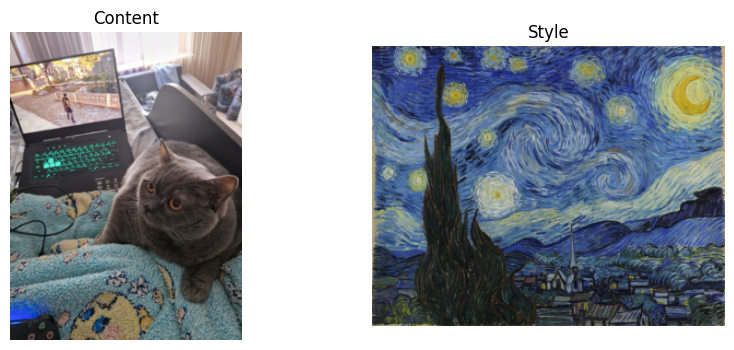

Step 50/300 | Loss: 1.13
Step 100/300 | Loss: 1.02
Step 150/300 | Loss: 1.01
Step 200/300 | Loss: 0.97
Step 250/300 | Loss: 1.04
Step 300/300 | Loss: 0.96


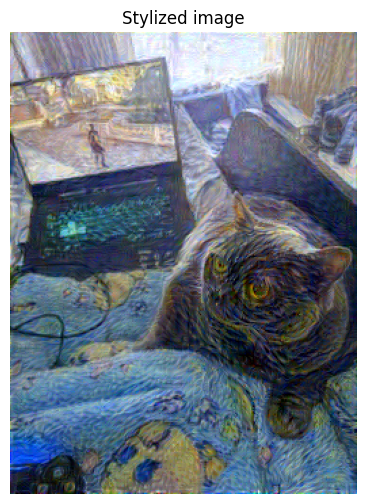

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# Завантаження зображень
# ----------------------------
imsize = 256 if device.type == "cuda" else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device)

content_img = load_image("content.jpg")
style_img   = load_image("style.jpg")

# ----------------------------
# Show image
# ----------------------------
def show(tensor, title=None):
    image = tensor.detach().cpu().clone()
    image = image.squeeze(0)
    image = image.permute(1, 2, 0)
    image = image.clamp(0, 1)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); show(content_img, "Content")
plt.subplot(1,2,2); show(style_img, "Style")
plt.show()

# ----------------------------
# VGG19 model
# ----------------------------
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False

# ----------------------------
# Feature extraction
# ----------------------------
def gram_matrix(x):
    b, c, h, w = x.size()
    features = x.view(c, h * w)
    gram = torch.mm(features, features.t())
    return gram / (c * h * w)

content_layers = ["21"]      # conv4_2
style_layers   = ["0", "5", "10", "19", "28"]

def extract_features(x, model):
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in content_layers or name in style_layers:
            features[name] = x
    return features

content_features = extract_features(content_img, vgg)
style_features   = extract_features(style_img, vgg)
style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

# ----------------------------
# згенероване зображення
# ----------------------------
generated = content_img.clone().requires_grad_(True)

optimizer = optim.Adam([generated], lr=0.02)

# ----------------------------
# Training
# ----------------------------
steps = 300
style_weight = 1e6
content_weight = 1

for step in range(1, steps + 1):
    optimizer.zero_grad()

    gen_features = extract_features(generated, vgg)

    content_loss = F.mse_loss(
        gen_features["21"], content_features["21"]
    )

    style_loss = 0
    for l in style_layers:
        gen_gram = gram_matrix(gen_features[l])
        style_loss += F.mse_loss(gen_gram, style_grams[l])

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}/{steps} | Loss: {total_loss.item():.2f}")

# ----------------------------
# Результат
# ----------------------------
plt.figure(figsize=(6,6))
show(generated, "Stylized image")
plt.show()

